#  Self-tuning random forests

A demonstration of ensembling and tuning in MLJ

In [13]:
# uncomment 2 lines for parallelized ensemble building:
# using Distributed
# addprocs()

using Suppressor
using MLJ
using Plots
pyplot()

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


Plots.PyPlotBackend()

Load a task (data plus learning objective):

In [14]:
task = load_boston()

SupervisedTask @ 1…76


Which models are available for this task?

In [15]:
models(task)

Dict{String,Any} with 4 entries:
  "MLJ"          => Any["KNNRegressor", "RidgeRegressor"]
  "DecisionTree" => Any["DecisionTreeRegressor"]
  "ScikitLearn"  => Any["SVMRegressor", "SVMLRegressor", "SVMNuRegressor"]
  "XGBoost"      => Any["XGBoostRegressor"]

## Evaluating a single decision tree

In [16]:
@load DecisionTreeRegressor

import MLJModels ✔
import DecisionTree ✔
import MLJModels.DecisionTree_.DecisionTreeRegressor ✔


In [17]:
tree = DecisionTreeRegressor()
mach = machine(tree, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms,rmslp1])

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/resampling.jl:91


(MLJ.rms = 7.058450107747526,
 MLJ.rmslp1 = 0.3275559703714572,)

## Creating a random forest by ensembling

In [18]:
forest = EnsembleModel(atom=tree)

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor @ 3…77,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng_seed = 0,
                               n = 100,
                               parallel = true,) @ 8…63

In [19]:
@more

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor(pruning_purity_threshold = 0.0,
                                                            max_depth = -1,
                                                            min_samples_leaf = 5,
                                                            min_samples_split = 2,
                                                            min_purity_increase = 0.0,
                                                            n_subfeatures = 0,
                                                            post_prune = false,),
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng_seed = 0,
                               n = 100,
                               parallel = true,) @ 8…63

We start by reducing number of features sampled at each tree node. We will use the square root of the
number of features, a common default:

In [20]:
tree.n_subfeatures = 3;

To get an idea of how many trees we need, we wrap our forest model in the task, pick a range for the ensemeble size, `n`, and generate learning curves (plots of model performance against `n`):

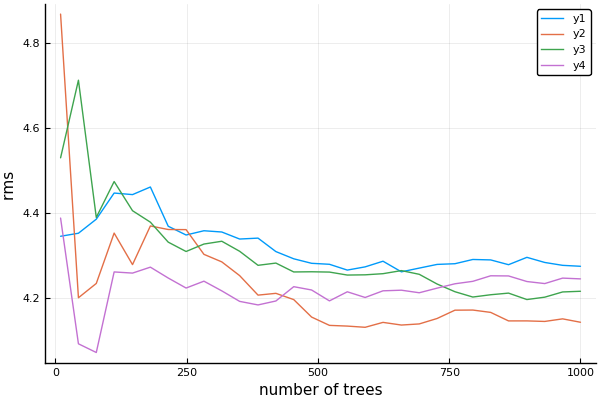

In [40]:
mach = machine(forest, task)
r = range(forest, :n, lower=10, upper=1000)
curves = learning_curve!(mach,
    resampling=Holdout(fraction_train=0.8),
    nested_range=(n=r,), 
    measure=rms, n=4)
@suppress plot(curves.parameter_values, curves.measurements,
     xlab="number of trees", ylab="rms ")

In [41]:
savefig("learningcurves.png")

In [42]:
forest.n = 300;

# Tuning

As `forest` is a composite model, it has nested hyperparameters:

In [43]:
params(forest) # all hyperparameters, as a named tuple

(atom = (pruning_purity_threshold = 0.0,
         max_depth = -1,
         min_samples_leaf = 5,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 3,
         post_prune = false,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng_seed = 0,
 n = 300,
 parallel = true,)

Let's define ranges for two hyperparameters we want to tune:

In [44]:
r1 = range(tree, :n_subfeatures, lower=1, upper=12)
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0);

We collate the ranges using by matching the pattern of `params(forest)` above, omitting parameters that don't change:

In [45]:
nested_ranges = (atom=(n_subfeatures=r1,), 
                 bagging_fraction=r2)

(atom = (n_subfeatures = NumericRange{n_subfeatures} @ 4…31,),
 bagging_fraction = NumericRange{bagging_fraction} @ 3…94,)

We now wrap our forest in tuning strategy to obtain a new "self-tuning" model!

In [46]:
tuned_forest = TunedModel(model=forest, 
                          tuning=Grid(resolution=12),
                          resampling=CV(nfolds=6),
                          nested_ranges=nested_ranges, 
                          measure=rms)

MLJ.DeterministicTunedModel(model = DeterministicEnsembleModel @ 8…63,
                            tuning = Grid @ 1…10,
                            resampling = CV @ 6…49,
                            measure = MLJ.rms,
                            operation = StatsBase.predict,
                            nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 4…31,), bagging_fraction = NumericRange{bagging_fraction} @ 3…94),
                            minimize = true,
                            full_report = true,) @ 1…88

In [47]:
params(tuned_forest)

(model = (atom = (pruning_purity_threshold = 0.0,
                  max_depth = -1,
                  min_samples_leaf = 5,
                  min_samples_split = 2,
                  min_purity_increase = 0.0,
                  n_subfeatures = 3,
                  post_prune = false,),
          weights = Float64[],
          bagging_fraction = 0.8,
          rng_seed = 0,
          n = 300,
          parallel = true,),
 tuning = (resolution = 12,
           parallel = true,),
 resampling = (nfolds = 6,
               parallel = true,
               shuffle = false,),
 measure = MLJ.rms,
 operation = StatsBase.predict,
 nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 4…31,),
                  bagging_fraction = NumericRange{bagging_fraction} @ 3…94,),
 minimize = true,
 full_report = true,)

## Evaluating the self-tuning random forest 

We evaluate our self-tuning random forest the same as any other model:

In [48]:
mach = machine(tuned_forest, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms, rmslp1])

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/resampling.jl:91


(MLJ.rms = 4.0594329002931975,
 MLJ.rmslp1 = 0.25803568683865385,)

Implicit in this evaluation is nested resampling: `evaluate!` fits `tuned_forest` on the training data and evaluates its performance on the 20% holdout test set. On the other hand, fitting `tuned_forest` means:
(i) searching over all parameters specified by `nested_ranges` above for the values optimizing performance, as estimated by cross-validation on the supplied data (80% of all data); and (ii)
and retraining a `forest` on *all* that data using the optimal parameters.

We can view the optimal `forest` hyperparameters:

In [49]:
fitted_params(mach)

(best_model = DeterministicEnsembleModel @ 6…43,)

In [50]:
best = fitted_params(mach).best_model
@show best.bagging_fraction
@show best.atom.n_subfeatures;

best.bagging_fraction = 0.5636363636363636
(best.atom).n_subfeatures = 7


And plot the performance estimates for the grid search:

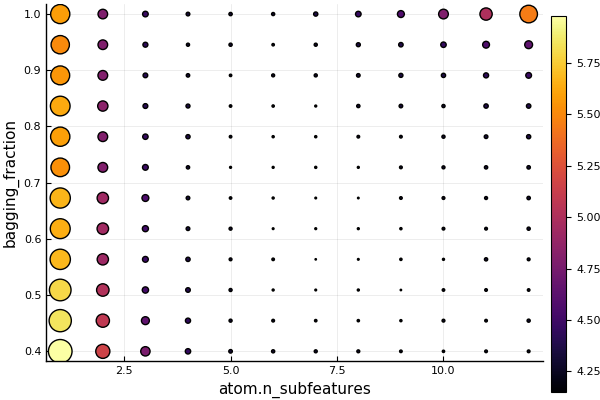

In [51]:
@suppress plot(mach)